In [12]:
# Author: Davide Aloi - PhD student - University of Birmingham
# Description: the purpose of this script is to calculate current density maps starting from electric magnitude maps (Emag)
# generated using ROAST. The script then correlates measures derived from each subject's current density map
# (i.e. median and max values of the current density in M1 and Thalamus) with DCM measures (i.e. self connectivity in M1,
# thalamo-cortical connectivity, etc). The script also generates different plots at various steps of the analysis. 

# Imports
import warnings
warnings.filterwarnings("ignore")
import os
import glob
import numpy as np
from nilearn import image, plotting
from nilearn.image import new_img_like
from scipy import ndimage
import scipy.io
from ipywidgets import IntProgress
from IPython.display import display
import time
from custom_functions.maps_functions import current_density_efield

In [2]:
# Main folder with data
main_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast\\' 

# MNI template for plotting and masking purposes
bg_img_map = image.load_img(os.path.join(main_folder, 'rois', 'MNI152_T1_1mm_Brain.nii'))
bg_img_map_smoothed = image.smooth_img(bg_img_map, fwhm=4) # MNI template smoothed (plotting purposes only)

# Parameters used: 
# Tissue conductivities used for the calculation of current density (1 = white matter, 2 = grey matter, 3 = CSF)
# These are the default values also used by ROAST
conductivities = [0.126, 0.276, 1.65]
fwhm_k = 4 # FWHM kernel used to smooth e-field maps and current density maps

# List of subjects
subjects = ['01','02','03','04','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','22','23','24']
#subjects = ['01','02']

## Loading DCM results 
# The .mat file contains 66 DCM matrices (anodal, cathodal and sham, per participant (N=22)).
# This is the result of the comparison Day-1 pre < Day-1 post.
# Connections included in the DCM (in this order): M1, Th, SMA, Cerebellum.
# The DCM quantifies the change in effective connectivity after stimulation as compared to pre stimulation.
# NB: I am interested only in anodal (indexes 0, 3, 6 ... 63) and sham (indexes 2, 5, 8... 65)
# NB: Each structure in the .mat file contains an array of size 16. To get the DCM values, each array has to be reshaped (4,4)
# and transposed, because the DCM "thinks" columns (from) by rows (to).
# NB: The Day_1_all_EPvalues.mat file was created with wp2a_roast_4_extract_single_dcms.m

dcm_data_day1_path = os.path.join(main_folder, 'wp2a_DCMfiles', 'Day1_all_EPvalues.mat') 
dcm_data_day1 = scipy.io.loadmat(dcm_data_day1_path)

## Loading AAL3 atlas and extracting M1 / Thalamus ROIs (regions of interest)
# AAL3 atlas paper: https://www.oxcns.org/papers/607%20Rolls%20Huang%20Lin%20Feng%20Joliot%202020%20AAL3.pdf 
AAl3_path = os.path.join(main_folder, 'rois', 'AAL3v1_1mm.nii')
AAL3_atlas = image.load_img(AAl3_path)

## Creating M1 and Th masks from the AAL3 atlas
# AAL3 index for M1 = 1
m1 = image.math_img("np.where(img == 1, 1, 0)", img = AAL3_atlas) 
# AAL3 index for TH = 121 - 149 (odd values only (left thalamus))
th = image.math_img("np.where(np.isin(img, np.arange(121, 150, 2)), 1, 0)", img = AAL3_atlas) 

In [3]:
# Where I'll save m1 self connections and all th->m1
all_m1m1 = []
all_thm1 = []
all_thth = []
all_m1th = []

# Where I'll save current density values for m1 and th for each subject (means, medians, max values)
all_m1_cd_means = []
all_th_cd_means = []
all_m1_cd_medians = []
all_th_cd_medians = []
all_m1_cd_max = []
all_th_cd_max = []

# For each subject, I save the emag map, the mask with WM, GM and CSF and the smoothed current density map and DCM matrices
all_emag_maps = []
all_masks = []
all_cd_maps = []
all_dcm_matrices = [] # DCM matrices Anodal
all_dcm_matrices_sham = [] # DCM matrices Sham


In [4]:
## Global variables
verbose = False # Print each subject's output

# Progress bar (it shows which subject is being processed)
f = IntProgress(min=0, max=len(subjects)) # instantiate the bar
f.style.bar_color = 'green'
display(f) # display the bar

# Index of the DCM results for subject 1, day 1 (anodal) (0, 3, 6 ... 64). If you want to know the index for sham, just add 2 
pos_dcm_res = 0  

# Looping all subjects
for sbj in subjects: 
    path = 'D:\\roast-chapter3\wp2a_copy\sub-' + sbj # Subject folder
    
    if verbose:
        print('Analysing subject: ' + sbj + '. Path: ' + path)
    
    # Loading DCM results
    # Transposing is needed because the PEB lists values column by row and not row by column...
    this_dcm = np.array(dcm_data_day1['ALLEP'][0][pos_dcm_res].todense().reshape((4,4))).T # Anodal
    this_dcm_sham = np.array(dcm_data_day1['ALLEP'][0][pos_dcm_res + 2].todense().reshape((4,4))).T  # Sham
    
    # Storing DCM matrices
    all_dcm_matrices.append(this_dcm)
    all_dcm_matrices_sham.append(this_dcm_sham)
    
    # Loading normalised Electric field magnitude map (emag) (unit: V/m) (e.g. wsub-*_emag.nii)
    # NB: The map was resampled and normalised with wp2a_roast_3_post_roast_preprocessing.m
    emag_map = image.load_img(glob.glob(path + '/wsub-*_T1_*_emag.nii'))
    
    # The above scan (and all the other ones that will be loaded) has 4 dimensions, with the 4th one referring to
    # the number of volumes. However, these is 3d data, I therefore drop the 4th dimension (i.e. from (157, 189, 156, 1)) to
    # (157, 189, 156). This is handy when performing mathematical operations on the scans.
    scan_shape = emag_map.get_fdata().shape[0:3] # Shape of the scan (should be = (157, 189, 156) for wp2a data)    
    emag_data = emag_map.get_fdata().reshape(scan_shape) # Data with 4th dimention in the array dropped
    emag_map = new_img_like(emag_map, emag_data) #  Restoring the data into a nibabel object
    
    # Resampling MNI anatomical file to emag map (so that they have the same shape).
    # This is done only once as the shape is the same for every participant's map.
    if not 'mni_resampled' in locals():
        mni_resampled = image.resample_to_img(bg_img_map, emag_map, interpolation = 'nearest')
        
    # Resampling ROIs to the dimention of the emag map. Again, this is done only once. 
    if not 'm1_resampled' in locals():
        m1_resampled = image.resample_to_img(m1, emag_map, interpolation = 'nearest')
        th_resampled = image.resample_to_img(th, emag_map, interpolation = 'nearest')
    
    # Loading mask containing WM (index 1), GM (2), CSF (3), bone (4), skin (5), air (6). (e.g. wsub-*T1*T2_masks.nii)
    # This map was created by Roast starting from masks segmented by SPM. ROAST then uses morphological operations
    # followed by simple heuristics to fill remaining holes (Huang et al., 2018).
    # ROAST scripts: binaryMaskGenerate.m and segTouchup.m.
    # NB: The mask was resampled and normalised with wp2a_roast_3_post_roast_preprocessing.m
    mask_touched_all_data = image.load_img(glob.glob(path + '/wsub-*T1*T2_masks.nii')).get_fdata().reshape(scan_shape) 
    mask_touched_all = new_img_like(emag_map, mask_touched_all_data) # Restoring the data into a nibabel object
    
    # Excluding from the mask everything that is not WM, GM and CSF (idx 1, 2 and 3 respectively)
    mask_touched = image.math_img("np.where(np.isin(img, np.arange(1, 4)), img, 0)", img = mask_touched_all) 
        
    # Excluding from mask_touched values that outside the brain using the MNI template
    # NB: I do this because the grey matter map of SPM has some values that are outside the brain.
    mask_touched_brain = image.math_img("np.where(img2 != 0, img, 0)", img = mask_touched, img2 = mni_resampled) 
    
    # Masking emag map using the mask_touched_brain mask, to keep only WM, GM and CSF values
    emag_map_brain = image.math_img("np.where(img2 != 0, img, 0)", img = emag_map, img2 = mask_touched_brain)
    
    ## Computing current density (J) for each tissue (WM, GM, CSF), using the electric field (E) and tissue conductivity (s)
    # of each voxel, in accordance with Ohm’s law: J = sE. For more info: help(current_density_efield)
    
    current_density = current_density_efield(emag_map_brain.get_fdata(), mask_touched_brain.get_fdata(), conductivities)
    current_density = new_img_like(emag_map, current_density) # Restoring data into nibabel object
    
    # Smoothing current density map with FWHM (4mm)
    current_density_sw = image.smooth_img(current_density, fwhm = fwhm_k)   
    
    # Smoothing emag map with FWHM (4mm). This is just for plotting purposes.
    emag_map_smoothed = image.smooth_img(emag_map_brain, fwhm = fwhm_k)
      
    # DCM connectivities I'm interested in: m1-m1, th-th, m1-th, th-m1. 
    m1m1 = this_dcm[0][0]
    thm1 = this_dcm[0][1]
    thth = this_dcm[1][1]
    m1th = this_dcm[1][0]
    
    # Saving the DCM values into separate lists
    all_m1m1.append(m1m1)
    all_thm1.append(thm1)
    all_m1th.append(m1th) 
    all_thth.append(thth) 
    
    # Masking current density map with M1 and Th ROIs
    cd_sw_m1 = image.math_img("img * img2", img = current_density_sw, img2 = m1_resampled) #Applying m1 mask
    cd_sw_th = image.math_img("img * img2", img = current_density_sw, img2 = th_resampled) #Applying th mask
    
    # Assigning NaNs to values = 0, to exclude non M1/Th voxels from the calculation of the mean / median / max values
    cd_sw_m1_nans = np.where(m1_resampled.get_fdata() == 0, np.nan, cd_sw_m1.get_fdata())
    cd_sw_th_nans = np.where(th_resampled.get_fdata() == 0, np.nan, cd_sw_th.get_fdata())

    # Calculating means, medians and max values
    m1_cd_mean = np.nanmean(cd_sw_m1_nans)
    th_cd_mean = np.nanmean(cd_sw_th_nans)
    m1_cd_median = np.nanmedian(cd_sw_m1_nans)
    th_cd_median = np.nanmedian(cd_sw_th_nans)
    m1_cd_max = np.nanmax(cd_sw_m1_nans)
    th_cd_max = np.nanmax(cd_sw_th_nans)
       
    # Saving means, medians and max values into their respective lists
    all_m1_cd_means.append(m1_cd_mean)
    all_th_cd_means.append(th_cd_mean)   
    all_m1_cd_medians.append(m1_cd_median)
    all_th_cd_medians.append(th_cd_median)  
    all_m1_cd_max.append(m1_cd_max)
    all_th_cd_max.append(th_cd_max)   
   
    if verbose:
        print('Mean Electric field in M1: ' + str(round(m1_cd_mean,3)))
        print('Mean Electric field in Th: ' + str(round(th_cdemag_mean,3)))
        print('Median Electric field in M1: ' + str(round(m1_cd_median,3)))
        print('Median Electric field in Th: ' + str(round(th_cd_median,3)))
        print('Max Electric field in M1: ' + str(round(m1_cd_max,3)))
        print('Max Electric field in Th: ' + str(round(th_cd_max,3)))
        print('\n')
    
        
    all_emag_maps.append(emag_map_smoothed)
    all_cd_maps.append(current_density_sw)
    all_masks.append(mask_touched_brain)
    
    # Moving to the next subject
    pos_dcm_res += 3
    f.value += 1 # signal to increment the progress bar (useless, very very useless)
    

IntProgress(value=0, max=22, style=ProgressStyle(bar_color='green'))

In [ ]:
# Saving results into two dictionaries. This is handy when running / plotting correlations.

cd_all_results = {'Medians M1': all_m1_cd_medians,'Medians Th': all_th_cd_medians,
                    'Max values M1': all_m1_cd_max,'Max values Th': all_th_cd_max}
dcm_all_results = {'M1M1': all_m1m1, 'M1Th': all_m1th, 'ThTh': all_thth, 'ThM1': all_thm1}


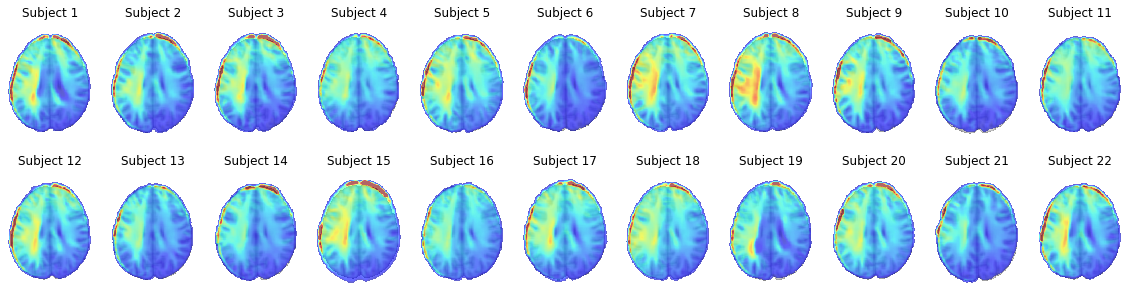

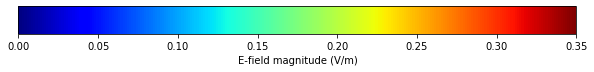

In [6]:
# Create a figure with multiple axes to plot each Emag map (smoothed)

import matplotlib.pyplot as plt

save_plt = True

fig, axes = plt.subplots(nrows = 2, ncols = 11, figsize = (20,5)) # Create Mega plot

vmin, vmax = 0, 0.35 # Color map min and max. 

subject = 0
for ax in axes.flatten():
    display = plotting.plot_roi(all_emag_maps[subject],
              #bg_img = bck_img_map_smoothed,
              display_mode = 'z',
              annotate = False,
              dim = 0.5,
              cmap = 'jet',
              cut_coords = [28],
              threshold = 0.01,
              vmin = vmin,
              vmax = vmax,
              alpha = 0.60,
              draw_cross = False,
              black_bg = False,
              axes = ax)
    ax.title.set_text('Subject ' + str(subject + 1))
    subject += 1 # Move to next subject

    if save_plt:
        plt.savefig('e-mag_all.jpg', format='jpg', dpi=400)

    
    
# Colorbar for the above brain plots
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='E-field magnitude (V/m)')    
if save_plt:
    plt.savefig('e-mag_all_cbar.jpg', format='jpg', dpi=400)

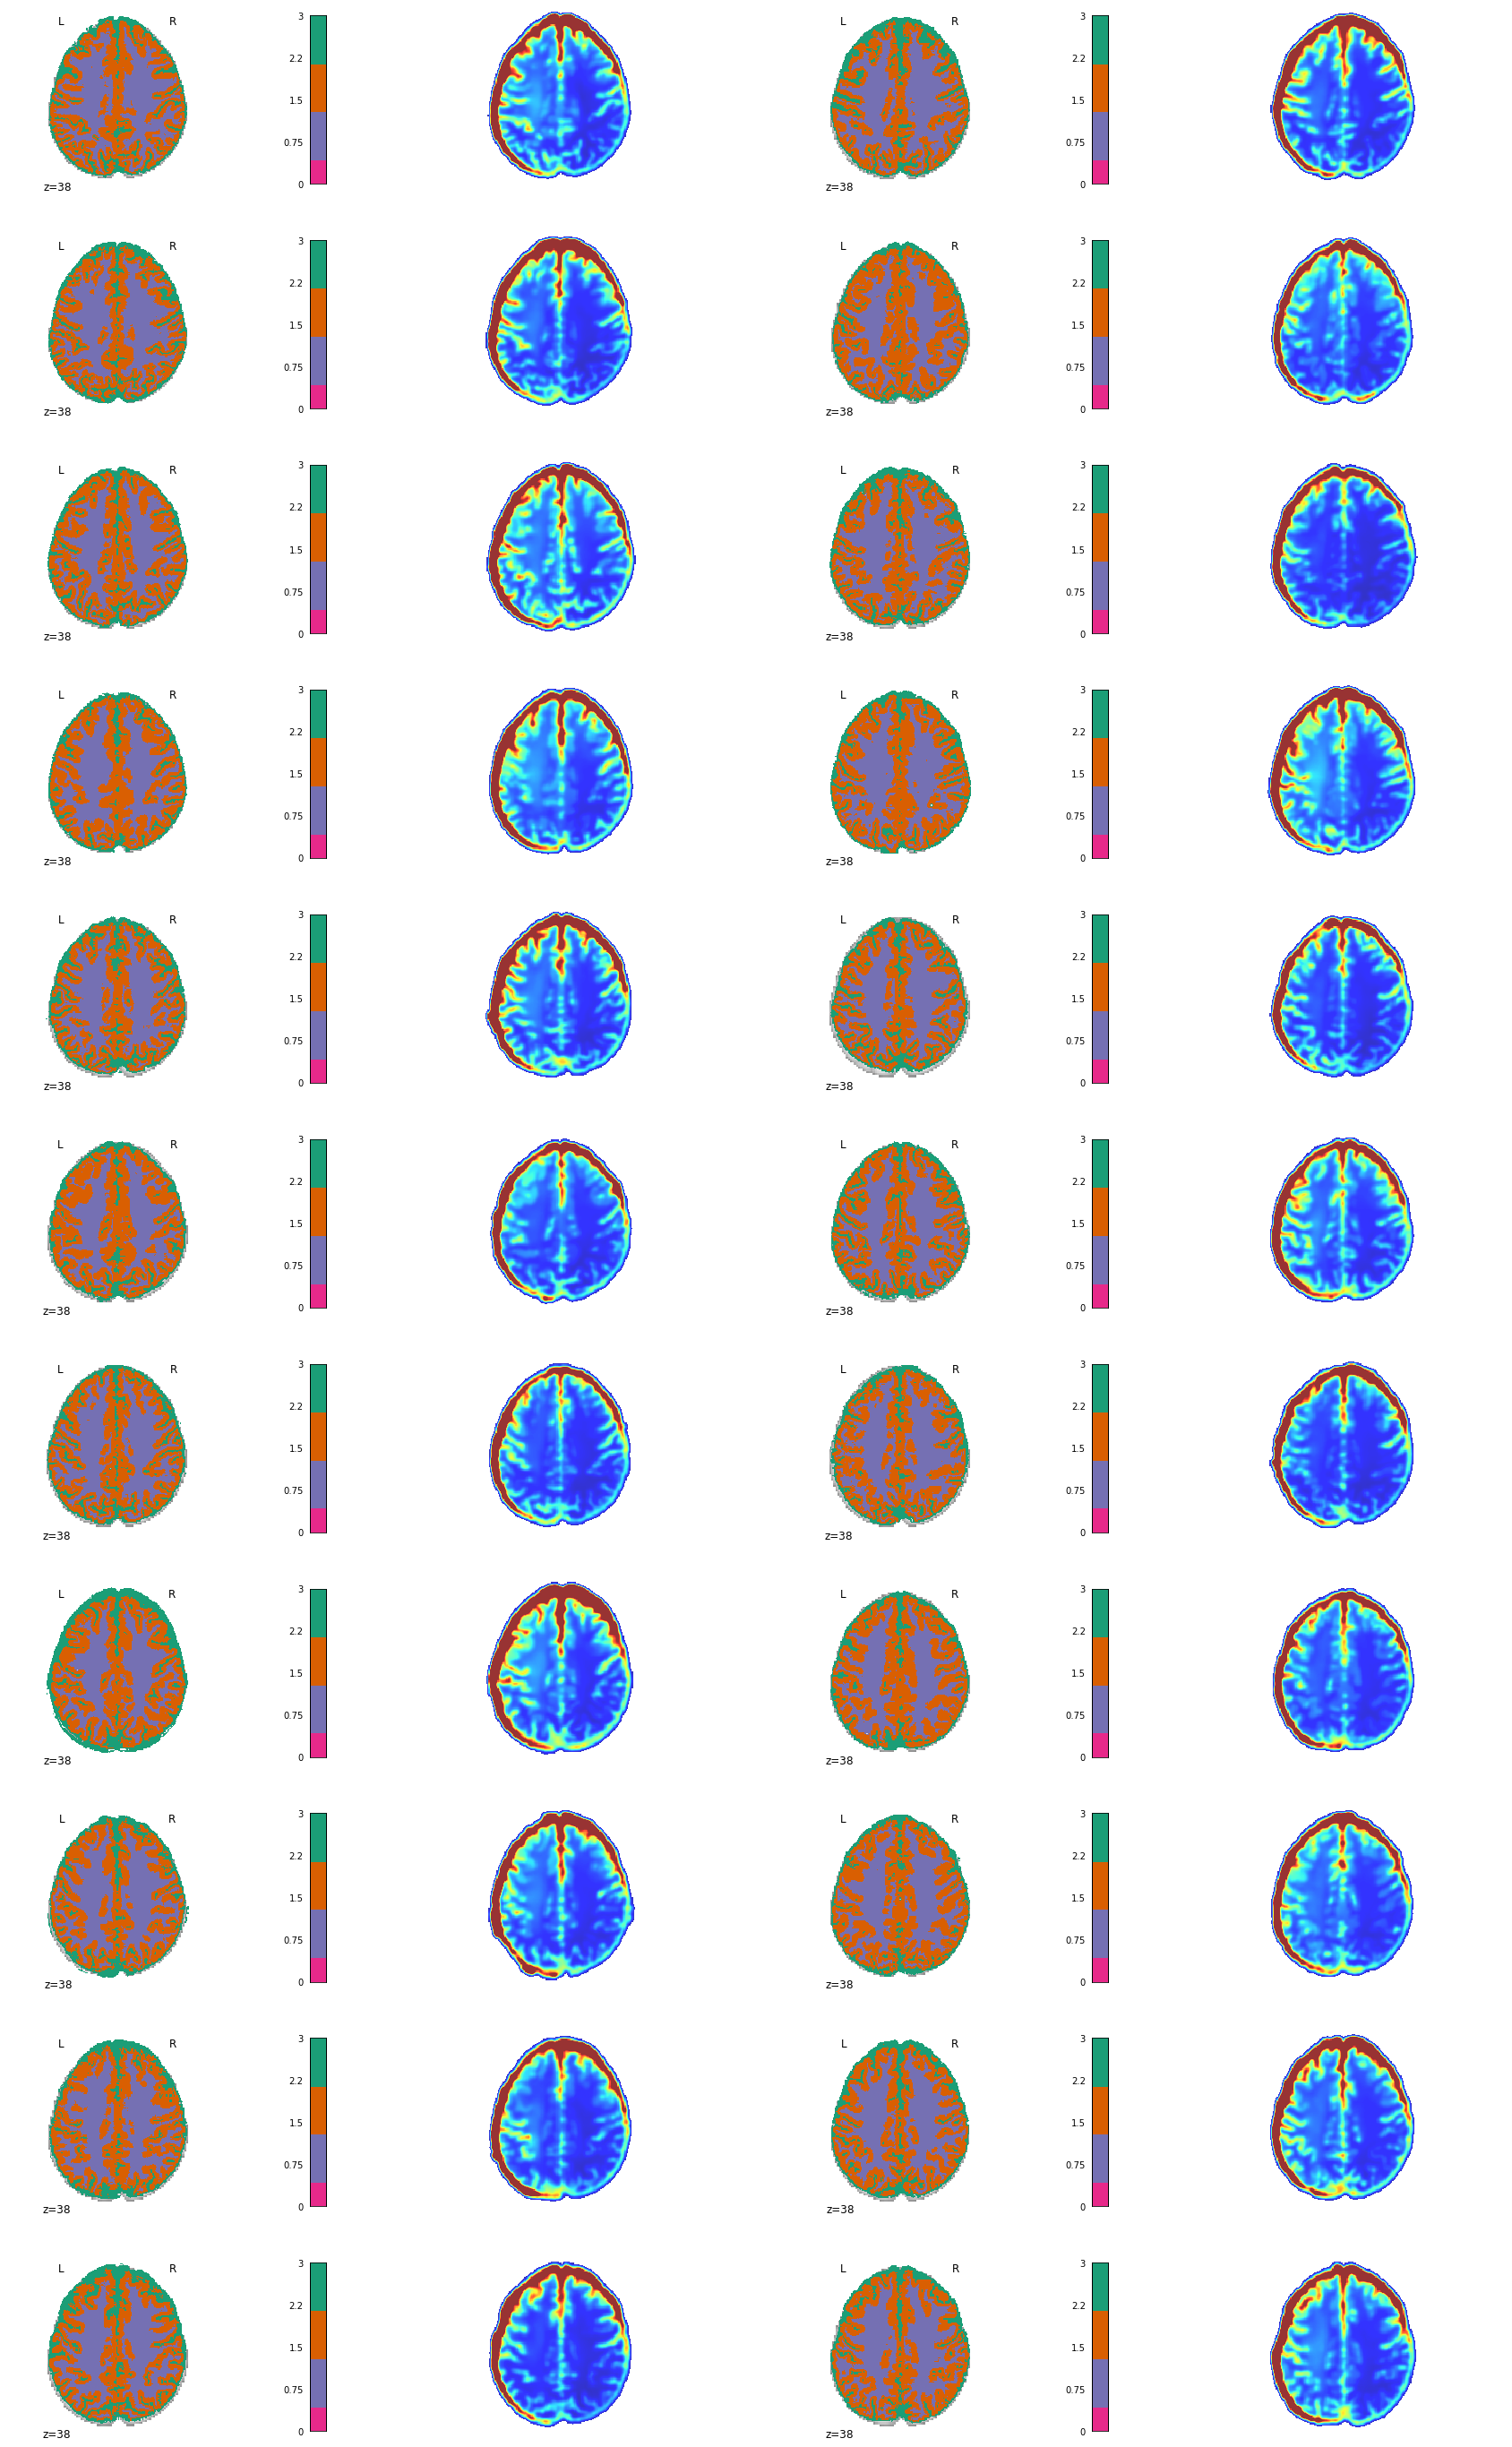

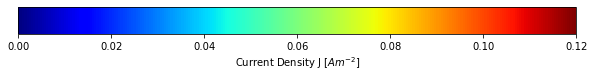

In [7]:
# Create a figure with multiple axes to plot each participant's mask and respective current density map (smoothed)

# Current density color map vmin and vmax
cd_vmin = 0
cd_vmax = 0.12
# Due to the smoothing you're going to have some small values of current density around the brain, which we won't show
cd_threshold = 0.005 

save_plt = True 
fig, axes = plt.subplots(nrows=11, ncols=4, figsize=(30,50)) # Mega plot

idx = 0 # Index of subplot in megaplot
sbj_idx = 0 # Index of subject (used to select the right map to show)
for sbj in subjects:

    row = int(idx/4); # Just to calculate the position of the sub-plot in the megaplot
    col = int(idx%4);
    
    
    # Plotting mask used for the calculation (WM + GM + CSF)
    display = plotting.plot_stat_map(all_masks[sbj_idx],
                                     cmap='Dark2_r',
                                     colorbar = True,
                                     display_mode = 'z',
                                     cut_coords = [38],                                     
                                     axes = axes[row][col]) 
    idx += 1
    
    row = int(idx/4); # Just to calculate the position of the sub-plot in the megaplot
    col = int(idx%4);
    idx += 1
    
    # Plotting smoothed current density map
    display = plotting.plot_roi(all_cd_maps[sbj_idx],
          bg_img = None,
          display_mode = 'z',
          annotate = False,
          cmap = 'jet',
          cut_coords = [38],
          threshold = cd_threshold,
          vmin = cd_vmin,
          vmax = cd_vmax,
          alpha = 0.80,
          draw_cross = False,
          black_bg = False,
          axes = axes[row][col])
    
    sbj_idx += 1
    # Progress bar (useless, very very useless)
    f.value += 1 # signal to increment the progress bar

if save_plt:
    plt.savefig('current_density_all.jpg', format='jpg', dpi=400)        
    
    
    
# Plotting current density color bar

fig, ax = plt.subplots(figsize = (10, 1))
fig.subplots_adjust(bottom = 0.5)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin = cd_vmin, vmax = cd_vmax)

fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap),
             cax = ax, orientation = 'horizontal', label = 'Current Density J [$Am^{-2}$]')      
    
if save_plt:
    plt.savefig('current_density_all_cbar.jpg', format='jpg', dpi=400)    

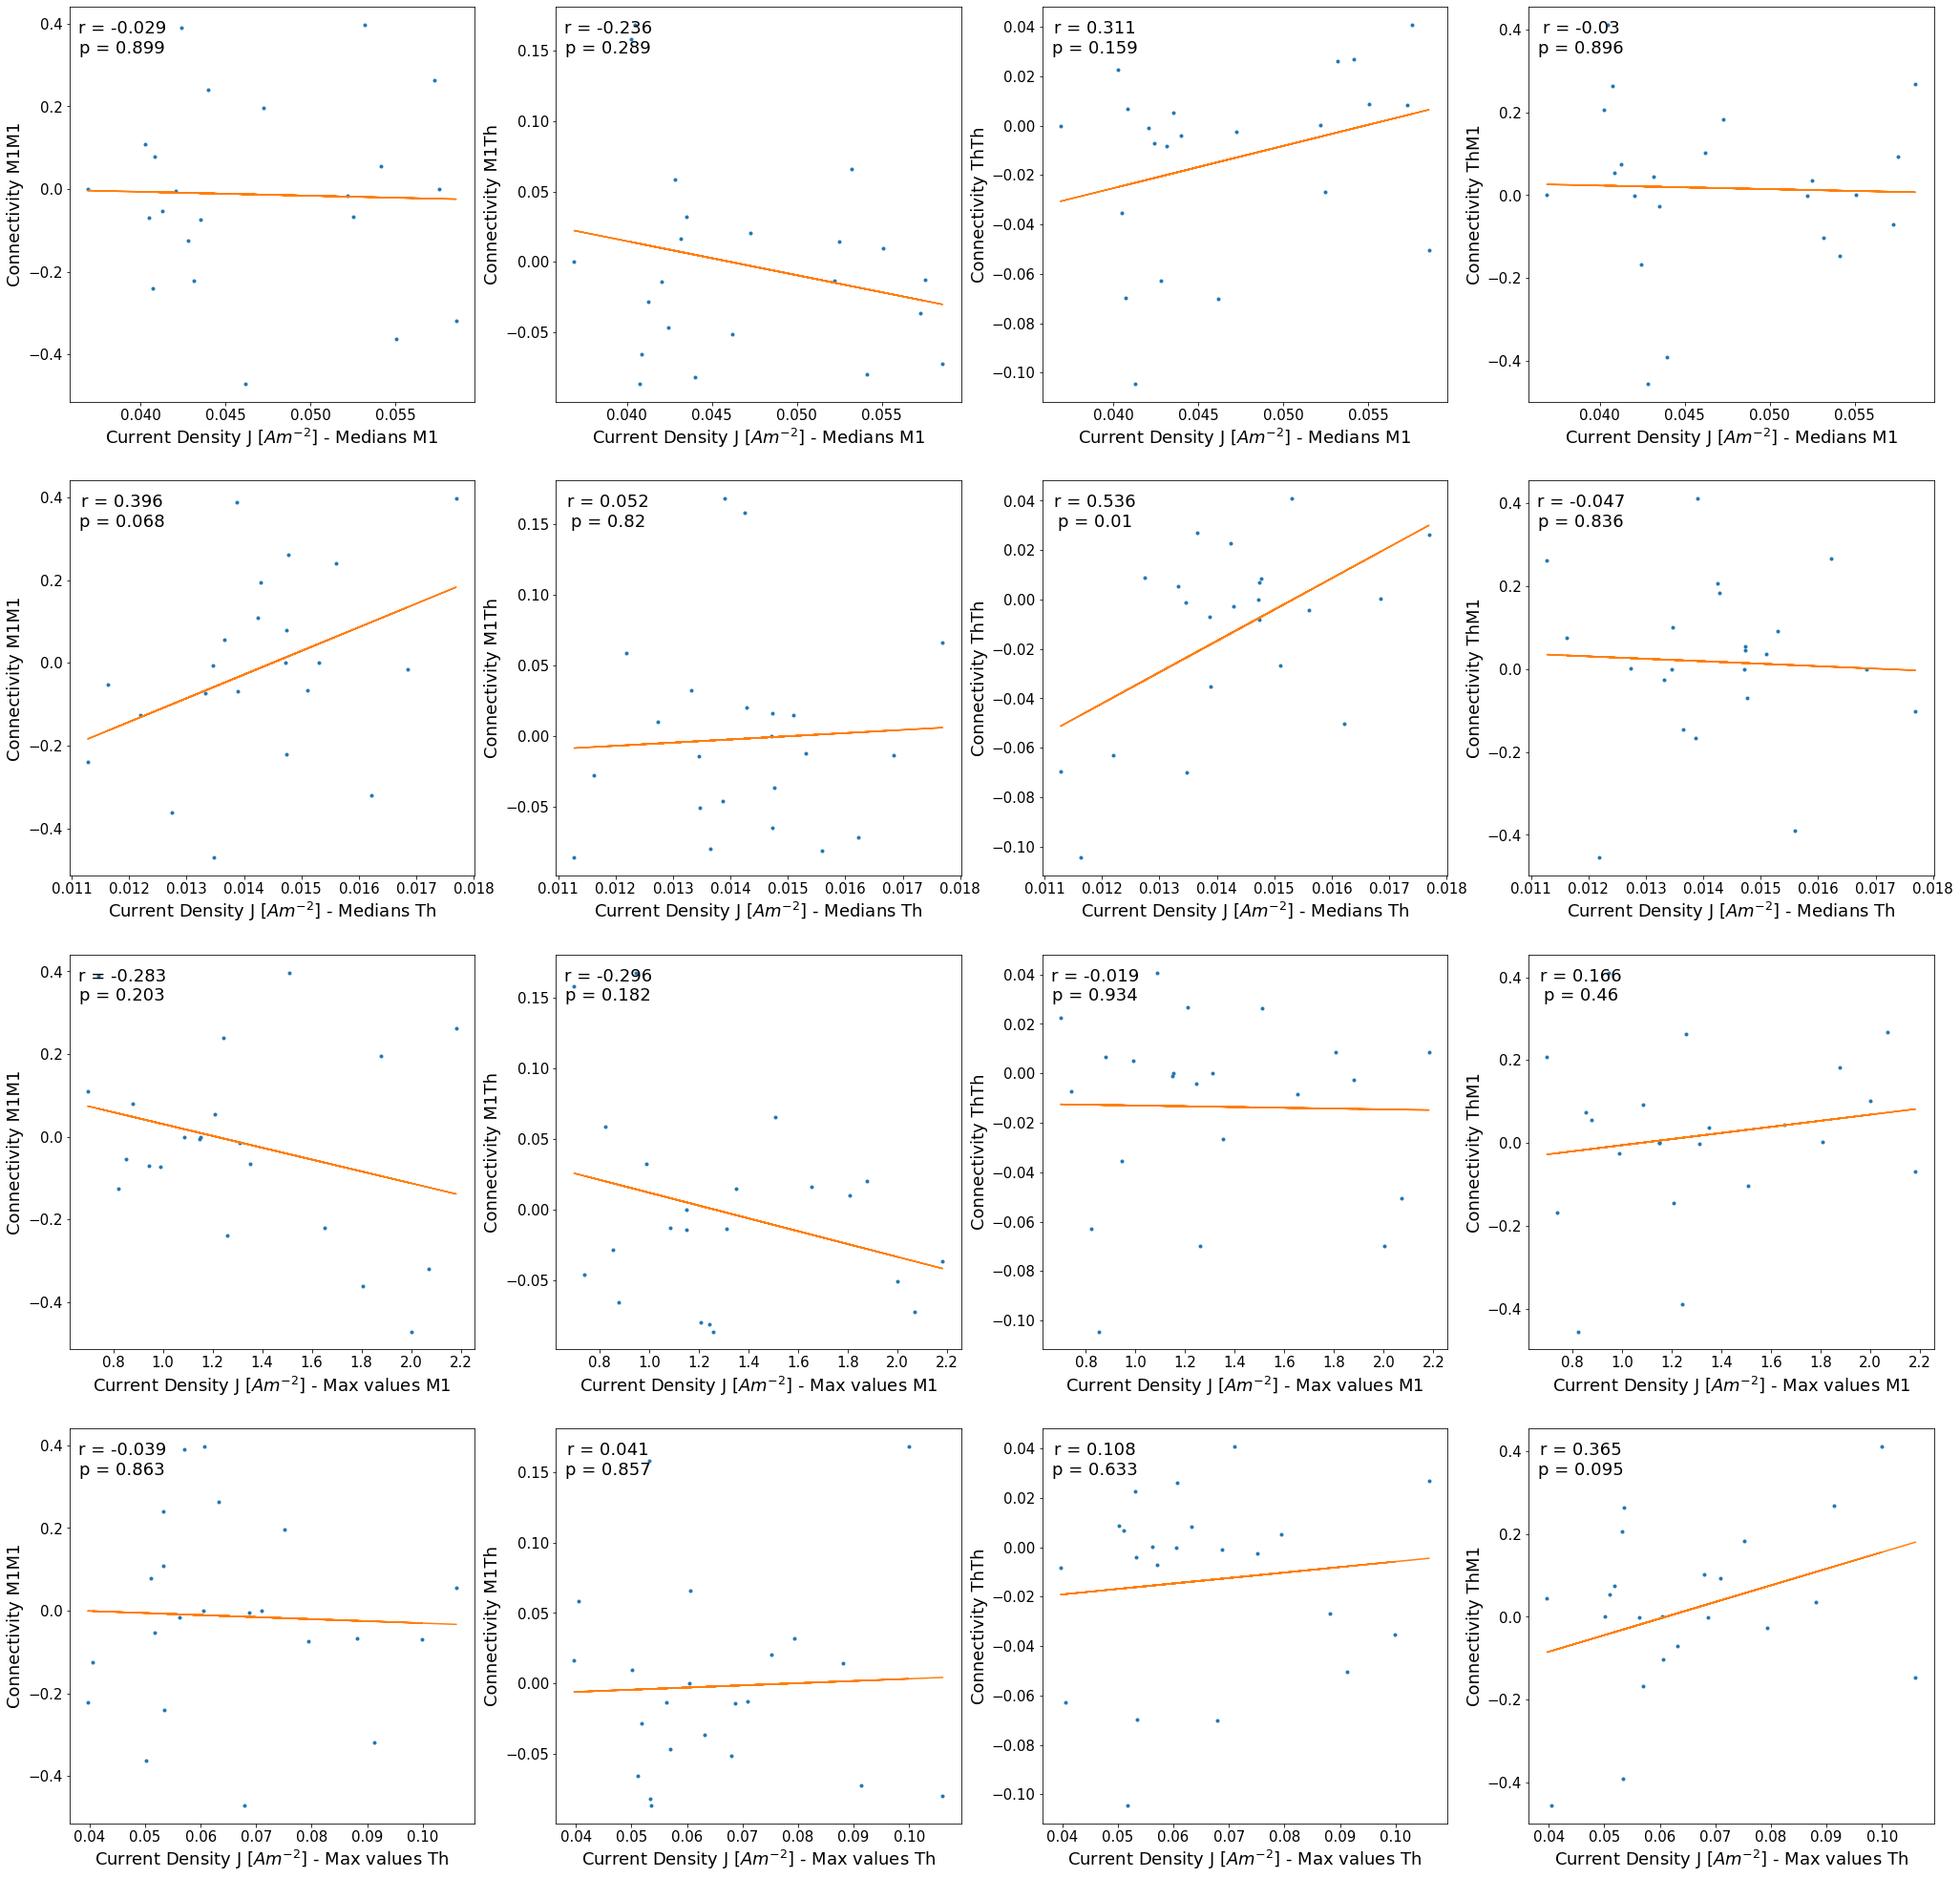

In [8]:
# Correlations between connectivity measures and Electric field magnitude medians and max values

from numpy.polynomial.polynomial import polyfit

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(35,35))

idx = 0
for cd_result in cd_all_results:
    for dcm_con in dcm_all_results:
        x = np.transpose(cd_all_results[cd_result])
        y = np.transpose(dcm_all_results[dcm_con])
        r,p  = scipy.stats.pearsonr(x, y)    # Pearson's r

        # Correlation Plot
        row = int(idx/4);
        col = int(idx%4); 
        b, m = polyfit(x, y, 1)
        
        axes[row][col].plot(x, y, '.')
        axes[row][col].plot(x, b + m * x, '-')
        #axes[row][col].title.set_text('Correlating ' + emag_measure + ' with ' + dcm_con)
        axes[row][col].set_xlabel('Current Density J [$Am^{-2}$] - ' + cd_result, fontsize = 18)
        axes[row][col].set_ylabel('Connectivity ' + dcm_con, fontsize = 18)
        axes[row][col].tick_params(axis='both', which='major', labelsize=15)
        axes[row][col].text(0.13, 0.92, 'r = ' + str(round(r,3)) + '\np = ' + str(round(p,3)), horizontalalignment='center',
                            verticalalignment='center', transform=axes[row][col].transAxes, fontsize = 18)
        idx += 1
 

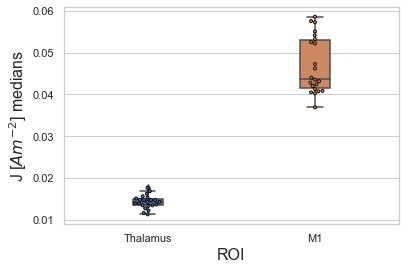

In [9]:
# Plotting current density medians for M1 and Th

import seaborn as sns, matplotlib.pyplot as plt, operator as op

cd_results_toplot = {'M1': all_m1_cd_medians,'Thalamus': all_th_cd_medians}

sorted_keys, sorted_vals = zip(*sorted(cd_results_toplot.items(), key = op.itemgetter(1)))

sns.set(context = 'notebook', style = 'whitegrid')
sns.utils.axlabel(xlabel = "ROI", ylabel = "J [$Am^{-2}$] medians", fontsize = 16)

sns.boxplot(data=sorted_vals, width = .18)
sns.swarmplot(data=sorted_vals, size = 3, edgecolor = "black", linewidth = .9)

# category labels
plt.xticks(plt.xticks()[0], sorted_keys)

plt.show()

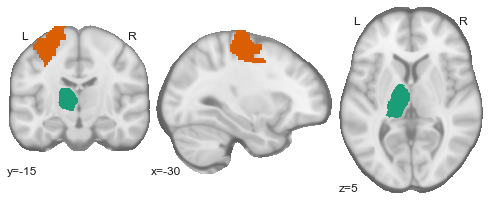

In [10]:
# Plotting AAL3 Left M1 and left thalamus ROIs used in the analyses

plotting.plot_stat_map(image.math_img('img + np.where(img2 == 1, 2,0)', img = m1, img2 = th),
                       bg_img = bg_img_map,
                       cmap = 'Dark2_r',
                       colorbar = False,
                       cut_coords = [-30,-15,5],
                       draw_cross = False,
                       black_bg = False)